# Feb 4th, 2022 (plot bold+ca)

**Motivation**: Fixed proportion plotting function, now shows runs as individual scatter points. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(
        1, 4, (10., 2), width_ratios=[1.7, 1, 1, 1.7])

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}

## Prepare

In [4]:
fig_dir = pjoin(tmp_dir, 'fig_proportion')
os.makedirs(fig_dir, exist_ok=True)

In [5]:
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p10-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

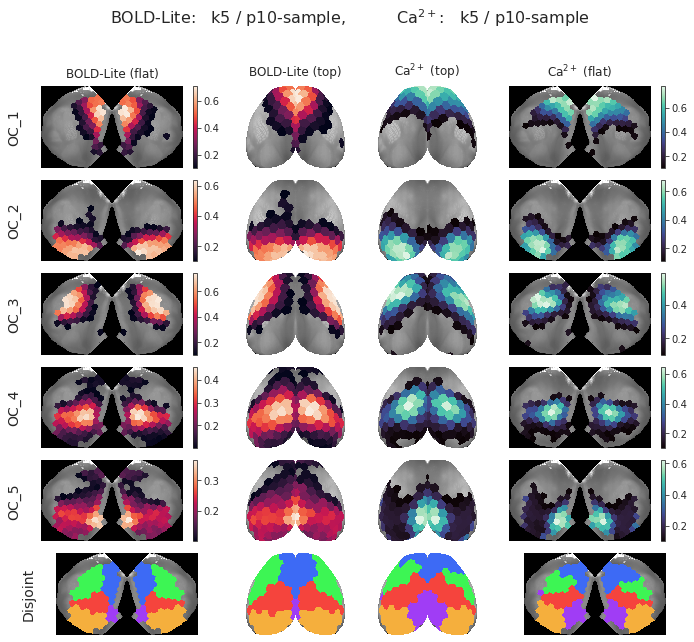

In [6]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [7]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99369, 2: 0.99514, 3: 0.99294, 4: 0.99334, 5: 0.99632, -1: 0.99428},
    {1: 0.97701, 2: 0.98851, 3: 0.96552, 4: 0.97701, 5: 1.0, -1: 0.98161}
)

In [8]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98681, 2: 0.99326, 3: 0.97899, 4: 0.99218, 5: 0.98576, -1: 0.9874},
    {1: 0.91954, 2: 0.98851, 3: 0.89655, 4: 0.95402, 5: 0.98851, -1: 0.94943}
)

## Plots: group

### BOLD-Lite

In [9]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_bold.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

In [10]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [11]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [12]:
b_grp = bootstrap(
    x=cut_prune,
    n_resamples=50000,
    batch=5,
    dims=dims,
    est=None,
)
b_grp_avg = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)
se_boot = bn.nanstd(b_grp_avg, 0, ddof=1)

In [13]:
df_bold = gr_bold.mk_boot_df(se_boot, cut_prune_anim)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/group_bold-lite_(2022_02_04).pdf

done.

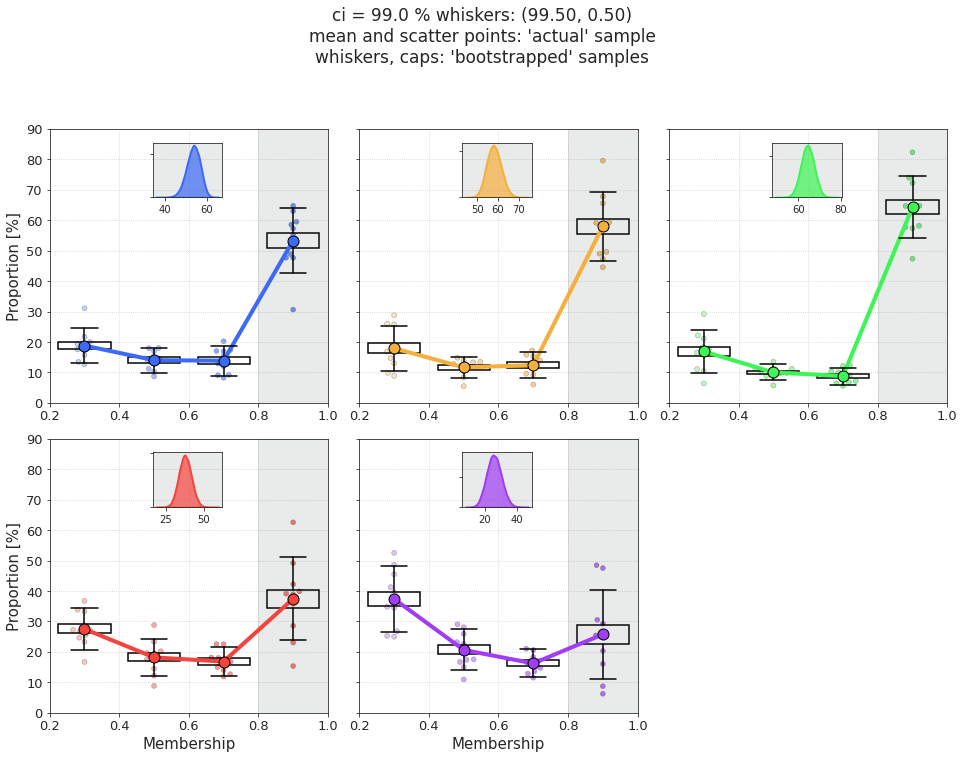

In [14]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_bold,
    inset_data=b_grp_avg[..., -1].T,
    save_file=pjoin(fig_dir, f"group_bold-lite_{now()}.pdf"),
    ylim=(0, 90),
)
figs[1]

### Ca2+

In [15]:
i, j, k = gr_ca.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

In [16]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [17]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [18]:
b_grp = bootstrap(
    x=cut_prune,
    n_resamples=50000,
    batch=5,
    dims=dims,
    est=None,
)
b_grp_avg = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)
se_boot = bn.nanstd(b_grp_avg, 0, ddof=1)

In [19]:
df_ca = gr_ca.mk_boot_df(se_boot, cut_prune_anim)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/group_ca2_(2022_02_04).pdf

done.

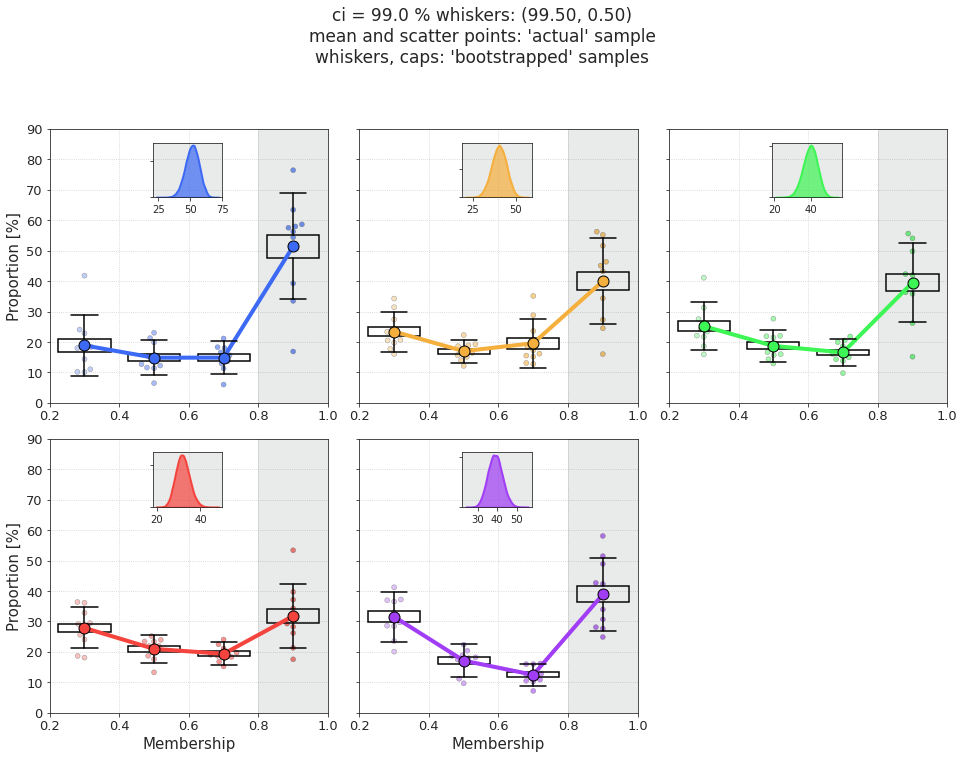

In [20]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_ca,
    inset_data=b_grp_avg[..., -1].T,
    save_file=pjoin(fig_dir, f"group_ca2_{now()}.pdf"),
    ylim=(0, 90),
)
figs[1]

### BOLD + Ca2

In [21]:
df = pd.concat([df_bold, df_ca])
df.reset_index(inplace=True)

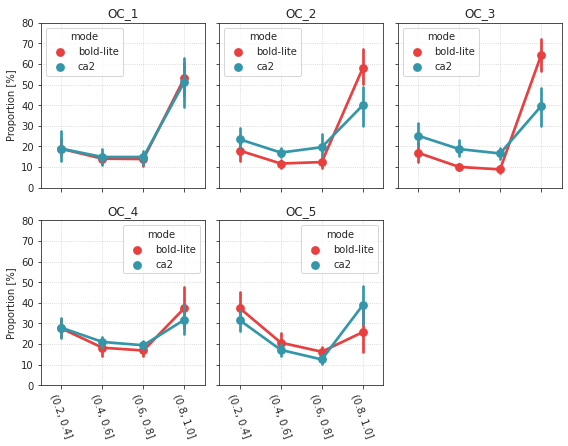

In [22]:
fig, axes = create_figure(2, 3, (8, 6.3), 'all', 'all')

oc_idxs = df['oc_idx'].unique()
for ax, i in zip(axes.flat, oc_idxs):
    sns.pointplot(
        data=df.loc[df['oc_idx'] == i],
        x='interval',
        y='mean',
        hue='mode',
        ci=99,
        palette=pal,
        ax=ax,
    )
    if i in [1, 4]:
        ylbl = 'Proportion [%]'
    else:
        ylbl = ''
    ax.set_ylabel(ylbl)
    ax.set_title(f'OC_{i}')
    ax.tick_params(axis='x', rotation=-70)
    ax.set_xlabel('')
    ax.set_ylim(0, 80)
    ax.grid()
trim_axs(axes, len(oc_idxs))
fig.savefig(pjoin(fig_dir, 'group_bold+ca2.pdf'), bbox_inches='tight')
plt.show()

## Plots: individual

### BOLD-Lite

In [23]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_bold.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

In [24]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [25]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [26]:
b_anim = bootstrap(
    x=cut_prune,
    n_resamples=50000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim_avg, 0, ddof=1)

In [27]:
df_bold = gr_bold.mk_boot_df(se_boot, cut_prune, False)

In [28]:
for anim in range(10):
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_bold.loc[df_bold['subject'] == anim + 1],
        inset_data=b_anim_avg[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_bold-lite_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
    )

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC01_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC02_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC03_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC04_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC05_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC06_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC07_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC08_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC09_(2022_02_04).p
df

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_bold-lite_sub-SLC10_(2022_02_04).p
df

done.

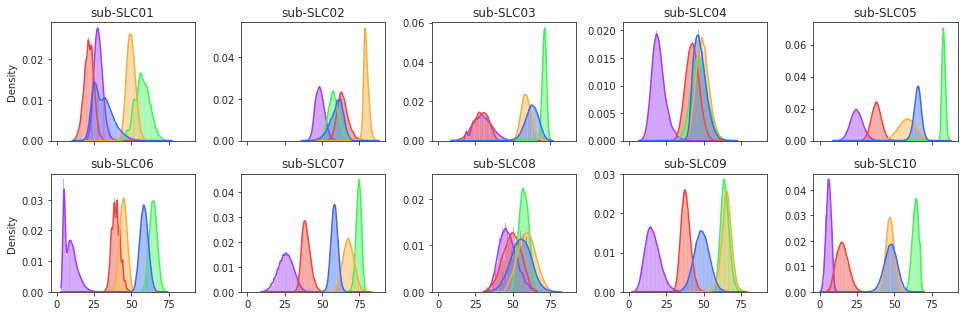

In [29]:
fig, axes = create_figure(2, 5, (13.5, 4.5), sharex='all')
for i in range(10):
    ax = axes.flat[i]
    sns.histplot(
        b_anim_avg[:, i, :, -1],
        palette=gr_bold.colors.values(),
        stat='density',
        legend=False,
        kde=True,
        ax=ax,
    )
    ax.set_title(mice.get_key(i + 1))
    if i % 5 != 0:
        ax.set_ylabel('')
        
plt.show()

In [30]:
for anim in range(10):
    fig, axes = create_figure(5, 3, (10, 16), 'all', 'all')
    for i in range(5):
        for j in range(3):
            a = 1 + 4 * j
            b = 1 + 4 * (j + 1)
            _df = df_bold.loc[
                (df_bold['subject'] == anim + 1) &
                (df_bold['run'].isin(range(a, b))) &
                (df_bold['oc_idx'] == i + 1)
            ]
            ax = axes[i, j]
            sns.pointplot(
                data=_df,
                x='interval',
                y='mean',
                hue='run',
                palette='muted',
                ax=ax,
            )
            if i == 0:
                t = f"Session {j + 1}"
                ax.set_title(t, fontsize=15, y=1.05)
            if j % 3 == 0:
                ylbl = 'Proportion [%]'
            else:
                ylbl = ''
            ax.set_ylabel(ylbl, fontsize=14)

            if j == 2:
                axtw = ax.twinx()
                axtw.set_ylabel(f"OC_{i + 1}", fontsize=15, rotation=-90, labelpad=30)
                axtw.yaxis.set_label_position("right")
                axtw.set_yticks([])

            ax.tick_params(axis='x', rotation=-70)
            ax.set_xlabel('')
            ax.grid()
    fig.savefig(pjoin(fig_dir, f'runs_bold-lite_{mice.get_key(anim + 1)}_{now()}.pdf'), bbox_inches='tight')
    plt.close()

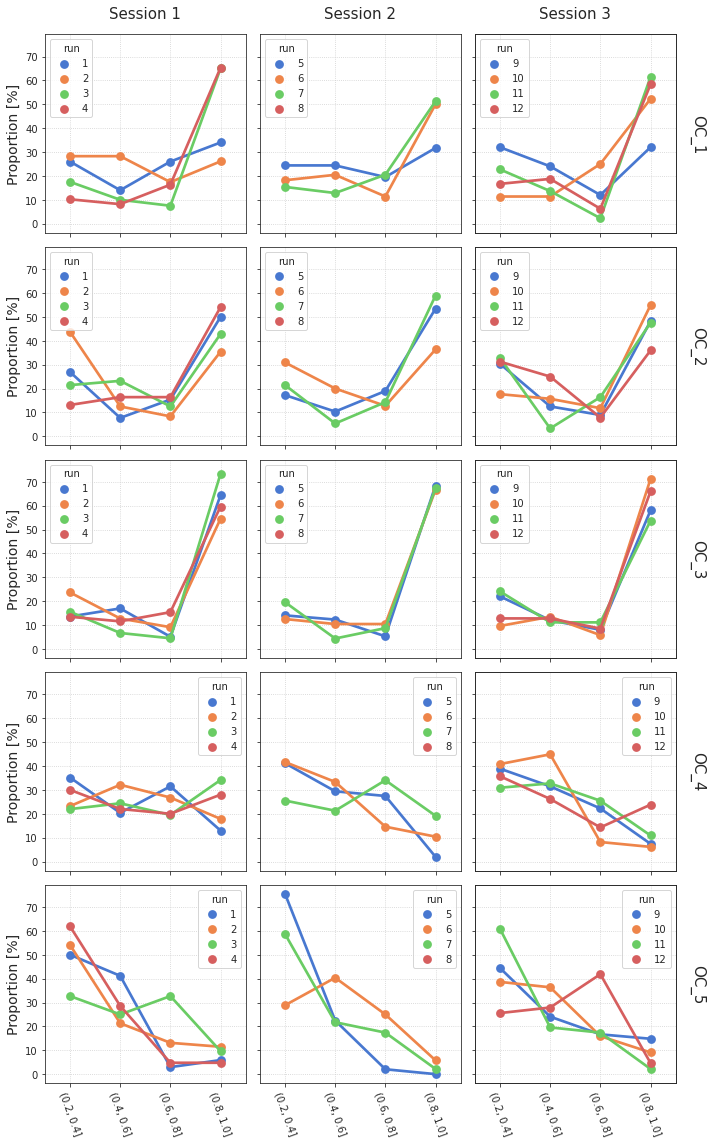

In [31]:
fig

### Ca2+

In [32]:
i, j, k = gr_ca.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

In [33]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [34]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [35]:
b_anim = bootstrap(
    x=cut_prune,
    n_resamples=50000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim_avg, 0, ddof=1)

In [36]:
np.isnan(cut_prune).sum(-1).sum(-1).reshape(len(cut_prune), -1)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [37]:
df_ca = gr_ca.mk_boot_df(se_boot, cut_prune, False)

In [38]:
for anim in range(10):
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_ca.loc[df_ca['subject'] == anim + 1],
        inset_data=b_anim_avg[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_ca2_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
    )

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC01_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC02_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC03_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC04_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC05_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC06_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC07_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC08_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC09_(2022_02_04).pdf

done.

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_proportion/indiv_ca2_sub-SLC10_(2022_02_04).pdf

done.

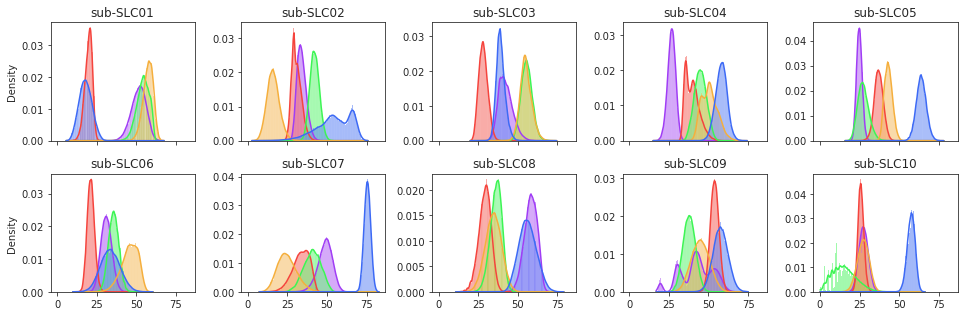

In [39]:
fig, axes = create_figure(2, 5, (13.5, 4.5), sharex='all')
for i in range(10):
    ax = axes.flat[i]
    sns.histplot(
        b_anim_avg[:, i, :, -1],
        palette=gr_ca.colors.values(),
        stat='density',
        legend=False,
        kde=True,
        ax=ax,
    )
    ax.set_title(mice.get_key(i + 1))
    if i % 5 != 0:
        ax.set_ylabel('')
        
plt.show()

In [40]:
for anim in range(10):
    fig, axes = create_figure(5, 3, (10, 16), 'all', 'all')
    for i in range(5):
        for j in range(3):
            a = 1 + 4 * j
            b = 1 + 4 * (j + 1)
            _df = df_ca.loc[
                (df_ca['subject'] == anim + 1) &
                (df_ca['run'].isin(range(a, b))) &
                (df_ca['oc_idx'] == i + 1)
            ]
            ax = axes[i, j]
            sns.pointplot(
                data=_df,
                x='interval',
                y='mean',
                hue='run',
                palette='muted',
                ax=ax,
            )
            if i == 0:
                t = f"Session {j + 1}"
                ax.set_title(t, fontsize=15, y=1.05)
            if j % 3 == 0:
                ylbl = 'Proportion [%]'
            else:
                ylbl = ''
            ax.set_ylabel(ylbl, fontsize=14)

            if j == 2:
                axtw = ax.twinx()
                axtw.set_ylabel(f"OC_{i + 1}", fontsize=15, rotation=-90, labelpad=30)
                axtw.yaxis.set_label_position("right")
                axtw.set_yticks([])

            ax.tick_params(axis='x', rotation=-70)
            ax.set_xlabel('')
            ax.grid()
    fig.savefig(pjoin(fig_dir, f'runs_ca2_{mice.get_key(anim + 1)}_{now()}.pdf'), bbox_inches='tight')
    plt.close()

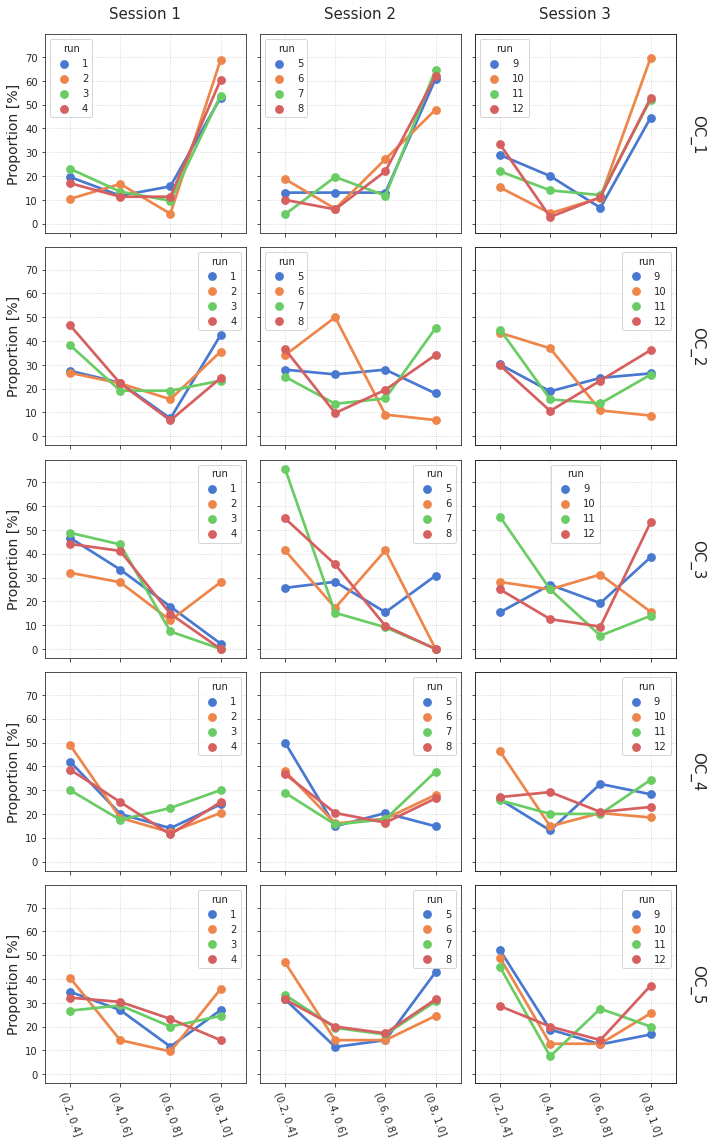

In [41]:
fig

### BOLD + Ca2

In [42]:
df = pd.concat([df_bold, df_ca])
df.reset_index(inplace=True)

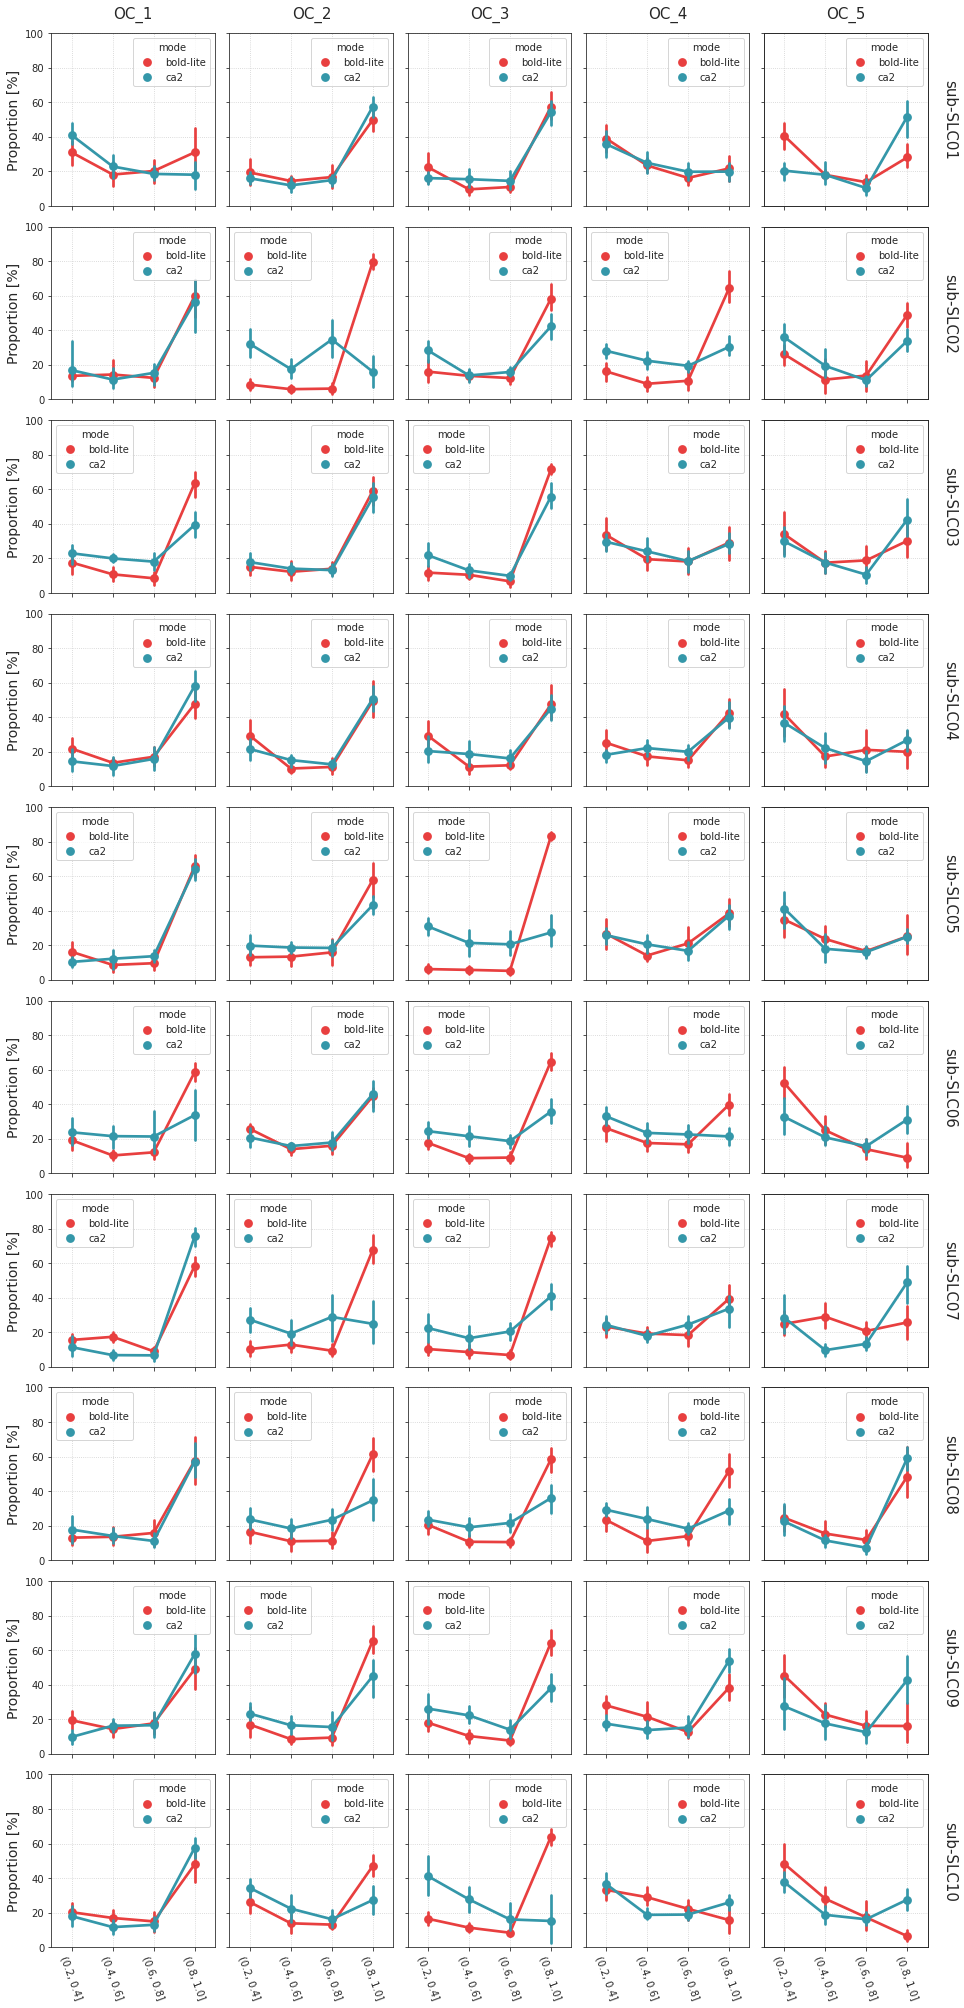

In [43]:
fig, axes = create_figure(10, 5, (13.5, 28), 'all', 'all')

oc_idxs = df['oc_idx'].unique()
for i in range(10):
    for j in range(5):
        ax = axes[i, j]
        _df = df.loc[
            (df['subject'] == i + 1) &
            (df['oc_idx'] == j + 1)
        ]
        sns.pointplot(
            data=_df,
            x='interval',
            y='mean',
            hue='mode',
            ci=99,
            palette=pal,
            ax=ax,
        )
        if i == 0:
            t = f"OC_{j + 1}"
            ax.set_title(t, fontsize=15, y=1.05)
        if j % 5 == 0:
            ylbl = 'Proportion [%]'
        else:
            ylbl = ''
        ax.set_ylabel(ylbl, fontsize=14)
        
        if j == 4:
            axtw = ax.twinx()
            axtw.set_ylabel(mice.get_key(i + 1), fontsize=15, rotation=-90, labelpad=30)
            axtw.yaxis.set_label_position("right")
            axtw.set_yticks([])
        
        ax.tick_params(axis='x', rotation=-70)
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
        ax.grid()
fig.savefig(pjoin(fig_dir, f'indiv_bold+ca2.pdf'), bbox_inches='tight')
plt.show()